### Install dependencies

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os

os.chdir('C:/Users/ACER/Downloads/ปี3/CPE393-text/week10_text-clustering')
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# %pip install -r requirements.txt

In [4]:
import re
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import pyplot as plt

from collections import Counter

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

### Read data from CSV

In [6]:
DATA = 'menuitems.csv'
df = pd.read_csv(DATA)
df.describe()

,Restaurant Name,Original food Item
count,4524,4524
unique,341,4330
top,Happy Joe's,Chocolate Chip Cookie
freq,48,11


In [7]:
df.head()

,Restaurant Name,Original food Item
0,Coffee Time,Garden Vegetable Sandwich
1,HoSan,Roasted Seaweed Snack
2,Weight Watchers,Muffins
3,Natural Sea,"Albacore Tuna, Solid White"
4,World of Beer,Caesar Salad with Grilled Flat Iron Steak


In [8]:
# Dataframe columns:
RESTAURANT = 'Restaurant Name'
ITEM = 'Original food Item'
EMBEDDING = 'Embedding'
CLUSTER = 'Cluster'

### Data cleaning

Very basic, remove non-alphabetic characters and measure like fl oz and inch

In [9]:
def clean_item(item):
    # Remove these measures as they are creating spurious clusters
    rem = ['oz', 'fl', 'inch']
    for r in rem:
        p = r'\b' + re.escape(r) + r'\b'
        item = re.sub(p, '', item, flags=re.IGNORECASE)

    # Keep only alphabetical characters
    item = re.sub(r'[^a-zA-Z\s]', '', item)

    return item

df[ITEM] = df[ITEM].apply(lambda x: clean_item(x))

### Create sentence embeddings for menu items

Using sentence-transformers library and a popular BERT based model from Hugging Face to generate the vector representations of the menu items.

In [10]:
bert = 'bert-base-nli-stsb-mean-tokens'

sentence_transformer = SentenceTransformer(bert)
embeddings = sentence_transformer.encode(df[ITEM], show_progress_bar=True)
print(f"Embedding shape: {embeddings.shape}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ACER\.cache\huggingface\hub\models--sentence-transformers--bert-base-nli-stsb-mean-tokens. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/142 [00:00<?, ?it/s]

Embedding shape: (4524, 768)


### Visualize embeddings

Visualize the embedding of the menu items using t-SNE. Couldn't see any clearly separated clusters in 2D using PCA, it was only capturing ~30% of the variance. So tried t-SNE, which shows more clearly separated clusters.

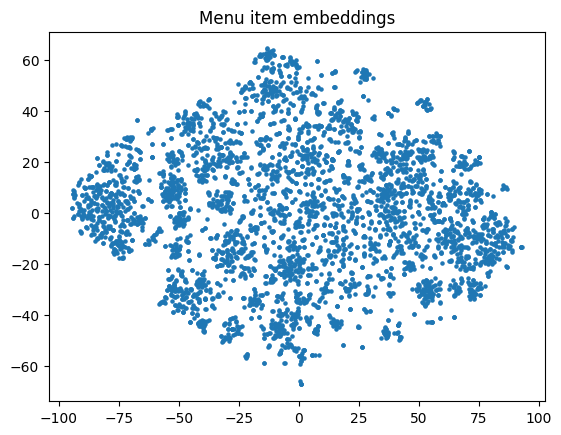

In [11]:
def visualize_embeddings(embeddings, size=10, labels=None, title=''):
    tsne = TSNE(n_components=2, learning_rate='auto')
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=size, c=labels)
    plt.title(title)
    plt.show()

visualize_embeddings(embeddings, size=5, title='Menu item embeddings')

### Dimensionality reduction using PCA

Use PCA to reduce dimensionality while retaining 90% of variance in data.

In [12]:
pca = PCA(n_components=0.9, svd_solver='full')
dim_reduced_embeddings = pca.fit_transform(embeddings)
print(f"Dimension reduced embedding shape: {dim_reduced_embeddings.shape}")

df[EMBEDDING] = list(dim_reduced_embeddings)

Dimension reduced embedding shape: (4524, 119)


### Vector Representation of restaurants

Average the vectors of the menu items of each restaurant to create a vector representation of the restaurant.

In [13]:
restaurant_df = df.drop(columns=[ITEM])
restaurant_df = restaurant_df.groupby(RESTAURANT).mean().reset_index()

### Find the best number of clusters

Use silhouette score (higher the better) to find the best k.

https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

Silhouette scores: {5: 0.06629093, 6: 0.06532997, 7: 0.0697031, 8: 0.06418236, 9: 0.06263634, 10: 0.069334745, 11: 0.03879209, 12: 0.05300174, 13: 0.042669073, 14: 0.06945901, 15: 0.060131475, 16: 0.044323314, 17: 0.04853446, 18: 0.05886813, 19: 0.041384168, 20: 0.05495237, 21: 0.045501266, 22: 0.061614096, 23: 0.036643423, 24: 0.046602778, 25: 0.02752235, 26: 0.061609738, 27: 0.075061046, 28: 0.069249526, 29: 0.043151107}


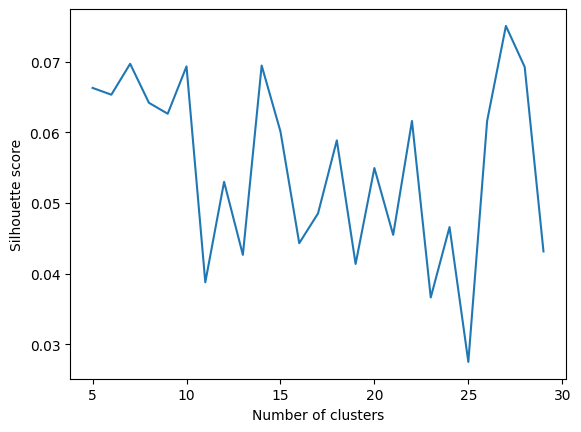

In [14]:
restaurant_embeddings = [embedding for embedding in restaurant_df[EMBEDDING].values]

candidate_k_values = list(range(5, 30))
slht_scores, kmeans_labels = [], []
for k in candidate_k_values:
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(restaurant_embeddings)

    kmeans_labels.append(kmeans.labels_)
    slht_scores.append(silhouette_score(restaurant_embeddings, kmeans.labels_))

silhouette_score_dict = {candidate_k_values[i]: slht_scores[i] for i in range(len(slht_scores))}

print(f"Silhouette scores: {silhouette_score_dict}")

plt.plot(candidate_k_values, slht_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

### Label restaurants with clusters

In [15]:
best_k = 15
restaurant_df[CLUSTER] = kmeans_labels[best_k - candidate_k_values[0]]

### Visualize restaurant clusters

Not very well defined clusters, other than few of them at the edge.

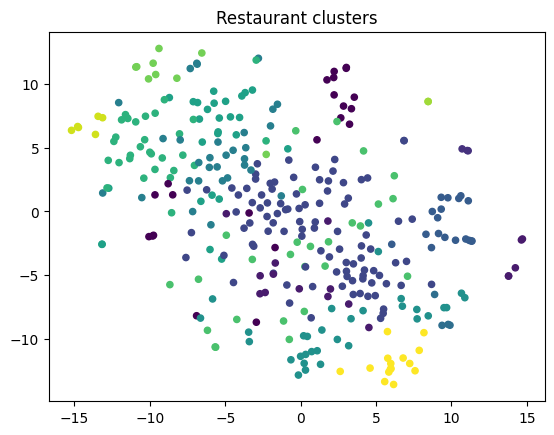

In [16]:
restaurant_embeddings = np.array([embedding for embedding in restaurant_df[EMBEDDING].values])

visualize_embeddings(restaurant_embeddings, size=20, labels=restaurant_df[CLUSTER].values, title='Restaurant clusters')

In [17]:
restaurant_df.sort_values(by=CLUSTER, inplace=True)
restaurant_df.to_csv('restaurants_clustered.csv', index=False, columns=[RESTAURANT, CLUSTER])

### Inspect clusters

Tried to look at what the most common words in the menu items for restaurants in each cluster are.

In [18]:

def most_common_words(x):
    word_salad = ' '.join(x.values).lower().split()
    ctr = Counter(word_salad)

    return ctr.most_common(3)

menuitems_clustered_df = df.merge(restaurant_df, on=RESTAURANT, how='left')
menuitems_clustered_df.groupby(CLUSTER)[ITEM].apply(most_common_words).reset_index()

,Cluster,Original food Item
0,0,"[(corn, 15), (bread, 10), (rye, 6)]"
1,1,"[(sauce, 24), (roasted, 8), (sweet, 7)]"
2,2,"[(salsa, 3), (classic, 1), (gourmet, 1)]"
3,3,"[(chicken, 251), (with, 188), (salad, 144)]"
4,4,"[(shrimp, 40), (salmon, 25), (wild, 19)]"
5,5,"[(beef, 4), (stick, 2), (peppered, 1)]"
6,6,"[(with, 58), (cheese, 58), (milk, 51)]"
7,7,"[(pizza, 224), (crust, 76), (chicken, 73)]"
8,8,"[(smoothie, 34), (kefir, 20), (milk, 17)]"
9,9,"[(cream, 128), (ice, 113), (chocolate, 100)]"


### Cluster sizes

Few oddly small clusters (5, 7), and couple of large clusters (4, 13).

Text(0, 0.5, 'Cluster ID')

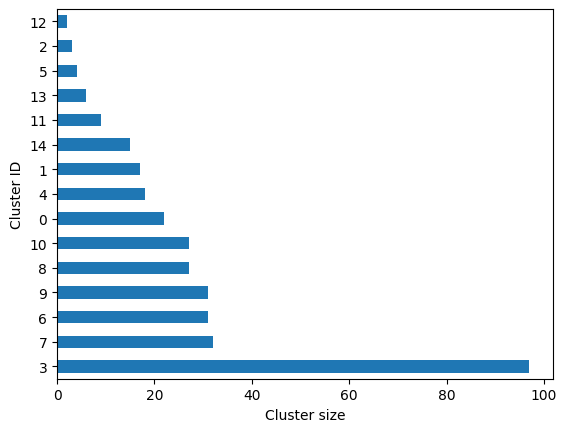

In [19]:
restaurant_df[CLUSTER].value_counts().plot(kind='barh')
plt.xlabel('Cluster size')
plt.ylabel('Cluster ID')

## Lab part
- implement sentence embeddings with complaint data

In [20]:
complaint = pd.read_pickle('consumer_complaint_dataset.data', compression='gzip')
complaint.drop_duplicates(inplace=True)
complaint.head()

,topic,input
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...
4,"Credit reporting, credit repair services, or o...",I have several accounts that the balance is in...


In [21]:
complaint.describe()

,topic,input
count,464561,464561
unique,18,464287
top,"Credit reporting, credit repair services, or o...",This particular account situation that is late...
freq,123323,7


In [22]:
df_prep = pd.DataFrame(columns=complaint.columns)

for topic in complaint['topic'].unique():
    temp = complaint[ complaint['topic'] == topic ].copy()
    
    if(len(temp) < 1000):
        df_prep = pd.concat([df_prep, temp])
    else:
        df_prep = pd.concat([df_prep, temp.sample(1000)])
        

df_prep.reset_index(drop=True, inplace=True)
df_prep.shape

(16305, 2)

In [23]:
stop_words = stopwords.words('english')
def clean_sentence(df, label):
    for ind, sentence in enumerate(df[label]):
        # remove punctuation
        punctuation_pattern = re.compile(r'[^\w\s]|_')
        text = re.sub(punctuation_pattern, '', sentence)

        # remove censored sensitive data
        pattern = re.compile(r'x+|X+')
        text = re.sub(pattern, '', text)
        
        # trim sentence and change to lowercase
        text = re.sub('\n', '', text)
        words = text.split(' ')
        words = [word.lower() for word in words if word.lower() not in stop_words]
        
        # lemmatization
        lemmatizer = WordNetLemmatizer()
        cleaned_text = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])
        cleaned_text = ' '.join([lemmatizer.lemmatize(word, pos='n') for word in cleaned_text.split(' ')])
        
        df.loc[ind, label] = cleaned_text
            

clean_sentence(df_prep, 'input')

### Create sentence embeddings from complaint

In [ ]:
bert = 'bert-base-nli-stsb-mean-tokens'

sentence_transformer = SentenceTransformer(bert)
embeddings = sentence_transformer.encode(df_prep['input'], show_progress_bar=True)
print(f"Embedding shape: {embeddings.shape}")

In [ ]:
def visualize_embeddings(embeddings, size=10, labels=None, title=''):
    tsne = TSNE(n_components=2, learning_rate='auto')
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=size, c=labels)
    plt.title(title)
    plt.show()

visualize_embeddings(embeddings, size=5, title='Complaint embeddings')

In [ ]:
pca = PCA(n_components=0.9, svd_solver='full')
dim_reduced_embeddings = pca.fit_transform(embeddings)
print(f"Dimension reduced embedding shape: {dim_reduced_embeddings.shape}")

df[EMBEDDING] = list(dim_reduced_embeddings)

### Vector representation of Topics

In [ ]:
topic_df = df_prep.drop(columns=['input'])
topic_df = topic_df.groupby('topic').mean().reset_index()

In [ ]:
topic_embeddings = [embedding for embedding in topic_df['topic'].values]

candidate_k_values = list(range(3, 11))
slht_scores, kmeans_labels = [], []
for k in candidate_k_values:
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(topic_embeddings)

    kmeans_labels.append(kmeans.labels_)
    slht_scores.append(silhouette_score(topic_embeddings, kmeans.labels_))

silhouette_score_dict = {candidate_k_values[i]: slht_scores[i] for i in range(len(slht_scores))}

print(f"Silhouette scores: {silhouette_score_dict}")

plt.plot(candidate_k_values, slht_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()